In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
events_data = pd.read_csv('event_data_train.csv')
submissions_data = pd.read_csv('submissions_data_train.csv')

In [3]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


Добавим колонку с датой и днем. 

In [4]:
events_data['date']  = pd.to_datetime(events_data.timestamp,unit='s')
events_data['day'] = events_data.date.dt.date

In [8]:
submissions_data['date']  = pd.to_datetime(submissions_data.timestamp,unit='s')
submissions_data['day'] = submissions_data.date.dt.date

In [5]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [10]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


Посчитаем кол-во различных событий для каждого пользователя

In [27]:
users_events = events_data.pivot_table(index='user_id',\
                                           columns='action',values='step_id',\
                                            aggfunc='count',fill_value=0).reset_index()
users_scores = submissions_data.pivot_table(index='user_id',\
                                            columns='submission_status',values='step_id',\
                                            aggfunc='count',fill_value=0).reset_index()

In [28]:
users_events.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [29]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


Время последнего и первого события пользователей

In [44]:
users_last_event = events_data.groupby('user_id',as_index=False)\
    .aggregate({'timestamp':'max'}).rename(columns={'timestamp':'last_timestamp'})
users_firts_event = events_data.groupby('user_id',as_index=False)\
    .aggregate({'timestamp':'min'}).rename(columns={'timestamp':'first_timestamp'})

Количество дней в которые пользователь совершал события

In [33]:
users_days = events_data.groupby('user_id',as_index=False).aggregate({'day':'nunique'})

In [34]:
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


Создадим датасет и соберем туда данные для каждого пользователя

In [45]:
users_data = users_days.copy()
users_data = users_data.merge(users_events,how='outer')
users_data = users_data.merge(users_scores,how='outer')
users_data = users_data.merge(users_last_event,how='outer')
users_data = users_data.merge(users_firts_event,how='outer')

In [49]:
users_data.head()

,user_id,day,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,first_timestamp,is_more_40
0,1,1,1,0,0,1,NaN,NaN,1472827464,1472827464,False
1,2,2,9,9,2,10,2.0,0.0,1519226966,1514383364,False
2,3,7,91,87,30,192,29.0,23.0,1444581588,1434358476,True
3,5,2,11,11,4,12,2.0,2.0,1499859939,1466156809,False
4,7,1,1,1,0,1,NaN,NaN,1521634660,1521634660,False


Добавим колонку, содержащую информацию набрал ли пользователь 40 баллов

In [48]:
users_data['is_more_40'] = users_data['passed'] > 40

### Теперь будем предсказывать наберет ли пользователь 40 баллов исходя из его первых двух дней активности.
Для этого обрежем данные его активности до двух первых дней

In [55]:
events_data_two_days = events_data.copy()
events_data_two_days = events_data_two_days.merge(users_firts_event,how='outer')
events_data_two_days = events_data_two_days[events_data_two_days.timestamp<=events_data_two_days.first_timestamp+2*24*60*60]

In [61]:
submissions_data_two_days = submissions_data.copy()
submissions_data_two_days = submissions_data_two_days.merge(users_firts_event,how='outer')
submissions_data_two_days = submissions_data_two_days[submissions_data_two_days.timestamp<=submissions_data_two_days.first_timestamp+2*24*60*60]

In [63]:
events_data_two_days.head()

,step_id,timestamp,action,user_id,date,day,first_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848


In [62]:
submissions_data_two_days.head()

,step_id,timestamp,submission_status,user_id,date,day,first_timestamp
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,1434345977
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,1434345977
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434345977
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,1434345977
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,1434345977


Те же данные которые мы считали для пользователей за все время посчитаем за первые два дня

In [70]:
users_events_two_days = events_data_two_days.pivot_table(index='user_id',\
                                           columns='action',values='step_id',\
                                            aggfunc='count',fill_value=0).reset_index()
users_scores_two_days = submissions_data_two_days.pivot_table(index='user_id',\
                                            columns='submission_status',values='step_id',\
                                            aggfunc='count',fill_value=0).reset_index()
users_days_two_days = events_data_two_days.groupby('user_id',as_index=False).aggregate({'day':'nunique'})
users_last_event_two_days = events_data_two_days.groupby('user_id',as_index=False)\
                                            .aggregate({'timestamp':'max'})\
                                            .rename(columns={'timestamp':'last_timestamp'})
users_firts_event_two_days = events_data_two_days.groupby('user_id',as_index=False)\
                                            .aggregate({'timestamp':'min'})\
                                            .rename(columns={'timestamp':'first_timestamp'})

In [71]:
users_data_two_days = users_days_two_days.copy()
users_data_two_days = users_data_two_days.merge(users_events_two_days,how='outer')
users_data_two_days = users_data_two_days.merge(users_scores_two_days,how='outer')
users_data_two_days = users_data_two_days.merge(users_last_event_two_days,how='outer')
users_data_two_days = users_data_two_days.merge(users_firts_event_two_days,how='outer')

## Решаем задачу классификации - наберет ли пользователь более 40 баллов.
Добавим метку класса к данным за три дня.

In [78]:
users_data_two_days = users_data_two_days.merge(users_data[['user_id','is_more_40']],how='outer')

In [87]:
users_data_two_days.head()

,user_id,day,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,first_timestamp,is_more_40
0,1,1,1,0,0,1,0.0,0.0,1472827464,1472827464,False
1,2,1,9,9,2,9,2.0,0.0,1514383555,1514383364,False
2,3,1,15,15,4,20,4.0,4.0,1434359582,1434358476,True
3,5,1,1,1,0,1,0.0,0.0,1466156809,1466156809,False
4,7,1,1,1,0,1,0.0,0.0,1521634660,1521634660,False


Заполним пропуски в колонках correct и wrong нулями

In [86]:
users_data_two_days[['correct','wrong']] = users_data_two_days[['correct','wrong']].fillna(value=0)

In [89]:
users_data_two_days.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19234 entries, 0 to 19233
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          19234 non-null  int64  
 1   day              19234 non-null  int64  
 2   discovered       19234 non-null  int64  
 3   passed           19234 non-null  int64  
 4   started_attempt  19234 non-null  int64  
 5   viewed           19234 non-null  int64  
 6   correct          19234 non-null  float64
 7   wrong            19234 non-null  float64
 8   last_timestamp   19234 non-null  int64  
 9   first_timestamp  19234 non-null  int64  
 10  is_more_40       19234 non-null  bool   
dtypes: bool(1), float64(2), int64(8)
memory usage: 1.5 MB


In [80]:
from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate

In [ ]:
X_train,X_test,y_train,y_test =  train_test_split(users_data_two_days.drop(columns=['user_id','is_more_40']),\
                                                  users_data_two_days['is_more_40'],\
                                                    test_size=0.2)

In [83]:
from sklearn.ensemble import RandomForestClassifier

In [122]:
forest_params = {'n_estimators':range(20,100,20),
                 'max_depth':range(2,12,2),
                 'min_samples_leaf':range(5,15),}
forest_model = RandomForestClassifier(random_state=0)
forest_search = GridSearchCV(estimator=forest_model,param_grid=forest_params,cv=4,n_jobs=-1)
forest_search.fit(X_train,y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': range(2, 12, 2),
                         'min_samples_leaf': range(5, 15),
                         'n_estimators': range(20, 100, 20)})

In [123]:
forest_search.best_params_

{'max_depth': 6, 'min_samples_leaf': 11, 'n_estimators': 80}

In [124]:
best_forest = forest_search.best_estimator_

In [125]:
from sklearn.metrics import auc,RocCurveDisplay,roc_curve

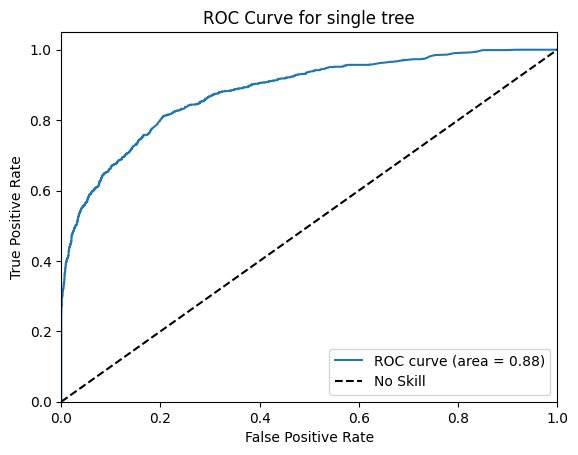

In [126]:
fpr, tpr, thresholds = roc_curve(y_test, best_forest.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for single tree')
plt.legend()
plt.show()

In [127]:
roc_auc

0.8806075619007596

In [97]:
from sklearn.ensemble import GradientBoostingClassifier

In [128]:
grad_boost_params = {'learning_rate':[0.1,0.5,1],
                'n_estimators':range(60,120,30),
                 'max_depth':range(2,12,4),
                 'min_samples_leaf':range(1,15,5),}
grad_boost_model = GradientBoostingClassifier(random_state=0)
grad_boost_search = GridSearchCV(estimator=grad_boost_model,param_grid=grad_boost_params,cv=4,n_jobs=-1)
grad_boost_search.fit(X_train,y_train)

GridSearchCV(cv=4, estimator=GradientBoostingClassifier(random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5, 1],
                         'max_depth': range(2, 12, 4),
                         'min_samples_leaf': range(1, 15, 5),
                         'n_estimators': range(60, 120, 30)})

In [129]:
grad_boost_search.best_params_

{'learning_rate': 0.5,
 'max_depth': 2,
 'min_samples_leaf': 6,
 'n_estimators': 90}

In [130]:
grad_boost_best = grad_boost_search.best_estimator_

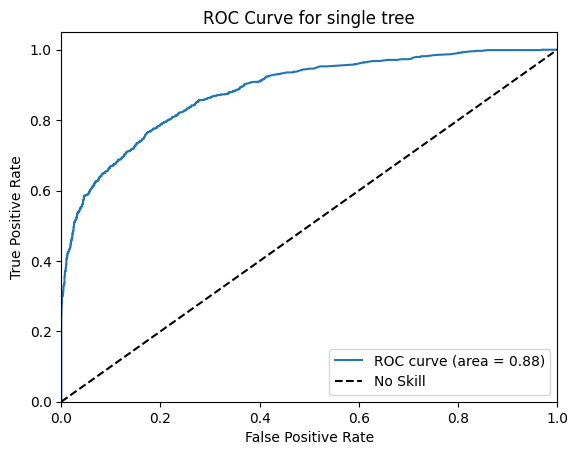

In [131]:
fpr, tpr, thresholds = roc_curve(y_test, grad_boost_best.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for single tree')
plt.legend()
plt.show()

In [132]:
roc_auc

0.883034197013429

### Теперь всю ту же предобработку сделаем для тестовых данных

In [107]:
events_data_test = pd.read_csv('events_data_test.csv')
submissions_data_test = pd.read_csv('submission_data_test.csv')

In [112]:
events_data_test['date'] = pd.to_datetime(events_data_test.timestamp,unit='s')
events_data_test['day'] = events_data_test.date.dt.date
submissions_data_test['date']  = pd.to_datetime(submissions_data_test.timestamp,unit='s')
submissions_data_test['day'] = submissions_data_test.date.dt.date

In [113]:
users_events_test = events_data_test.pivot_table(index='user_id',\
                                           columns='action',values='step_id',\
                                            aggfunc='count',fill_value=0).reset_index()
users_scores_test = submissions_data_test.pivot_table(index='user_id',\
                                            columns='submission_status',values='step_id',\
                                            aggfunc='count',fill_value=0).reset_index()

In [114]:
users_last_event_test = events_data_test.groupby('user_id',as_index=False)\
    .aggregate({'timestamp':'max'}).rename(columns={'timestamp':'last_timestamp'})
users_firts_event_test = events_data_test.groupby('user_id',as_index=False)\
    .aggregate({'timestamp':'min'}).rename(columns={'timestamp':'first_timestamp'})

In [115]:
users_days_test = events_data_test.groupby('user_id',as_index=False).aggregate({'day':'nunique'})

In [152]:
users_data_test = users_days_test.copy()
users_data_test = users_data_test.merge(users_events_test,how='outer')
users_data_test = users_data_test.merge(users_scores_test,how='outer')
users_data_test = users_data_test.merge(users_last_event_test,how='outer')
users_data_test = users_data_test.merge(users_firts_event_test,how='outer')

In [153]:
user_id_test = users_data_test[['user_id']]

In [166]:
user_id_test

,user_id
0,4
1,6
2,10
3,12
4,13
...,...
6179,26791
6180,26795
6181,26796
6182,26799


In [154]:
users_data_test.drop(columns='user_id',inplace=True)

In [157]:
users_data_test[['correct','wrong']] = users_data_test[['correct','wrong']].fillna(value=0)

In [159]:
users_data_test.head()

,day,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,first_timestamp
0,1,1,1,0,1,0.0,0.0,1529331707,1529331707
1,1,1,1,0,1,0.0,0.0,1546889407,1546889407
2,1,2,2,0,6,0.0,0.0,1534593770,1534585756
3,1,11,9,4,14,1.0,0.0,1537348641,1537348474
4,2,70,70,35,105,29.0,36.0,1533162170,1533034354


Обучим GradientBoostingClassifier на всей трейн выборку

In [139]:
users_data_two_days.head()

,user_id,day,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,first_timestamp,is_more_40
0,1,1,1,0,0,1,0.0,0.0,1472827464,1472827464,False
1,2,1,9,9,2,9,2.0,0.0,1514383555,1514383364,False
2,3,1,15,15,4,20,4.0,4.0,1434359582,1434358476,True
3,5,1,1,1,0,1,0.0,0.0,1466156809,1466156809,False
4,7,1,1,1,0,1,0.0,0.0,1521634660,1521634660,False


In [142]:
grad_boost_params = {'learning_rate':[0.1,0.5,1],
                'n_estimators':range(60,120,30),
                 'max_depth':range(2,12,4),
                 'min_samples_leaf':range(1,15,5),}
grad_boost_model = GradientBoostingClassifier(random_state=0)
grad_boost_search = GridSearchCV(estimator=grad_boost_model,param_grid=grad_boost_params,cv=4,n_jobs=-1)
grad_boost_search.fit(users_data_two_days.drop(columns=['user_id','is_more_40']),users_data_two_days['is_more_40'])

GridSearchCV(cv=4, estimator=GradientBoostingClassifier(random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5, 1],
                         'max_depth': range(2, 12, 4),
                         'min_samples_leaf': range(1, 15, 5),
                         'n_estimators': range(60, 120, 30)})

In [143]:
grad_boost_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 2,
 'min_samples_leaf': 1,
 'n_estimators': 90}

Значит будем обучать GradientBoostingClassifier с такими параметрами

In [160]:
grad_boost_best = GradientBoostingClassifier(random_state=0,learning_rate=0.1,\
                                             max_depth=2,min_samples_leaf=1,n_estimators=90)
grad_boost_best.fit(users_data_two_days.drop(columns=['user_id','is_more_40']),users_data_two_days['is_more_40'])

GradientBoostingClassifier(max_depth=2, n_estimators=90, random_state=0)

In [161]:
predictions = grad_boost_best.predict_proba(users_data_test)

In [165]:
predictions[:,1]

array([0.02655645, 0.02655645, 0.0314134 , ..., 0.05278897, 0.08041303,
       0.01060679])

In [170]:
user_id_test['is_gone'] = predictions[:,1]

/var/folders/dg/74szjjv1501f2y2zn89nmlnw0000gn/T/ipykernel_43180/3742492436.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_id_test['is_gone'] = predictions[:,1]


In [175]:
user_id_test

,user_id,is_gone
0,4,0.026556
1,6,0.026556
2,10,0.031413
3,12,0.057566
4,13,0.920412
...,...,...
6179,26791,0.026556
6180,26795,0.026556
6181,26796,0.052789
6182,26799,0.080413


In [ ]:
user_id_test.to_csv('submission.csv', index=False)

In [177]:
user_id_test.user_id.nunique()

6184